In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

files = glob.glob('D:/University4/BigData/lab2/data/rollingsales_*.xlsx')

df = pd.concat((pd.read_excel(file,engine='openpyxl') for file in files), ignore_index=True)

# Додаємо ті стовпці які будемо аналізувати
all_data = df[['BOROUGH', 'NEIGHBORHOOD','BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT','TOTAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE','SALE PRICE','SALE DATE']].copy()


# Замінюємо значення  BOROUGH з цифр на назви 
all_data.loc[:,'BOROUGH'] = all_data['BOROUGH'].replace({1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'})

# Замінюємо формат значення  
all_data['SALE DATE'] = pd.to_datetime(all_data['SALE DATE'], format='%Y-%m-%d')
all_data['TAX CLASS AT PRESENT'] = all_data['TAX CLASS AT PRESENT'].str.strip()


all_data = all_data.dropna(subset=['SALE PRICE'])  # Вилучення рядків з NaN
all_data = all_data[all_data['SALE PRICE'] != 0]

# Замінюємо 0 та NaN значення
all_data = all_data.dropna(subset=['SALE PRICE'])  
all_data = all_data[all_data['SALE PRICE'] != 0]
min_land_square_feet = all_data[all_data['LAND SQUARE FEET']> 0]['LAND SQUARE FEET'].min()
min_gross_square_feet = all_data[all_data['GROSS SQUARE FEET'] > 0]['GROSS SQUARE FEET'].min()
# min_gross_sale_price = all_data[all_data['SALE PRICE'] > 0]['SALE PRICE'].min()

all_data['LAND SQUARE FEET'] = all_data['LAND SQUARE FEET'].fillna(min_land_square_feet).astype(int)
all_data['GROSS SQUARE FEET'] = all_data['GROSS SQUARE FEET'].fillna(min_gross_square_feet).astype(int)
# all_data['SALE PRICE'] = all_data['SALE PRICE'].fillna(min_gross_sale_price).astype(int)
# all_data.loc[all_data['SALE PRICE'] == 0, 'SALE PRICE'] = min_gross_sale_price
all_data['TOTAL UNITS'] = all_data['TOTAL UNITS'].fillna(1).astype(int)
all_data.loc[all_data['TOTAL UNITS'] == 0, 'TOTAL UNITS'] = 1
# all_data.loc['TOTAL UNITS'] = all_data['TOTAL UNITS'].replace(0, 1)


all_data['LAND SQUARE FEET'] = all_data['LAND SQUARE FEET'].astype(int)
all_data['GROSS SQUARE FEET'] = all_data['GROSS SQUARE FEET'].astype(int)
all_data['TOTAL UNITS'] = all_data['TOTAL UNITS'].astype(int)
all_data['SALE PRICE'] = all_data['SALE PRICE'].astype(int)

# Додаємо стовпці BUILDING TYPE та PRICE PER SQFT
use_class_mapping = {
    'RESIDENTIAL': ['FAMILY', 'RESIDENTIAL', 'APARTMENTS'],
    'NON-RESIDENTIAL': ['OFFICE', 'STORE', 'GARDENS', 'PARKING', 'FACTORY', 'GARAGES']
}

# Функція для визначення категорії на основі значення Planning Use Class
def determine_use_class(description):
    for use_class, keywords in use_class_mapping.items():
        for keyword in keywords:
            if keyword in description.upper():
                return use_class
    return 'ELSE'

all_data['BUILDING TYPE'] = all_data['BUILDING CLASS CATEGORY'].apply(determine_use_class)
all_data['PRICE PER SQFT'] = all_data['SALE PRICE'] / all_data['GROSS SQUARE FEET']

print(all_data)


             BOROUGH NEIGHBORHOOD     BUILDING CLASS CATEGORY  \
0              Bronx     BATHGATE     01 ONE FAMILY DWELLINGS   
1              Bronx     BATHGATE     01 ONE FAMILY DWELLINGS   
2              Bronx     BATHGATE     01 ONE FAMILY DWELLINGS   
3              Bronx     BATHGATE     01 ONE FAMILY DWELLINGS   
5              Bronx     BATHGATE     02 TWO FAMILY DWELLINGS   
...              ...          ...                         ...   
73157  Staten Island      WOODROW  05 TAX CLASS 1 VACANT LAND   
73158  Staten Island      WOODROW  05 TAX CLASS 1 VACANT LAND   
73159  Staten Island      WOODROW  05 TAX CLASS 1 VACANT LAND   
73160  Staten Island      WOODROW  05 TAX CLASS 1 VACANT LAND   
73161  Staten Island      WOODROW          22 STORE BUILDINGS   

      TAX CLASS AT PRESENT BUILDING CLASS AT PRESENT  TOTAL UNITS  \
0                        1                        A1            1   
1                        1                        A1            1   
2           

In [3]:
import pandas as pd

# Перевірка на NaN значення у стовпці 'SALE PRICE'
has_nan = all_data['SALE PRICE'].isna().any()

# Перевірка на 0 значення у стовпці 'SALE PRICE'
has_zero = (all_data['SALE PRICE'] == 0).any()

if has_nan:
    print("У стовпці 'SALE PRICE' є NaN значення")

if has_zero:
    print("У стовпці 'SALE PRICE' є 0 значення")

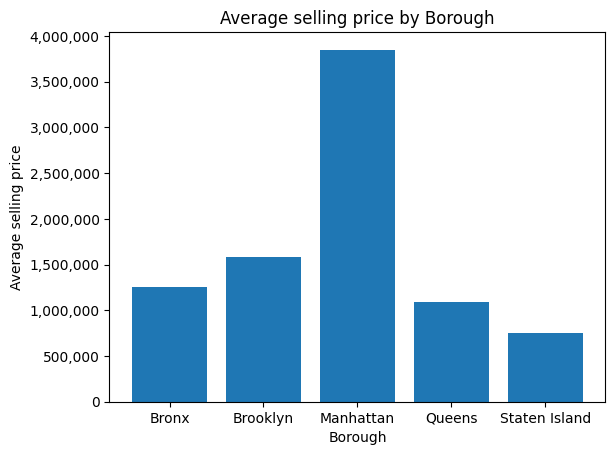

In [4]:
average_price_by_borough = all_data.groupby('BOROUGH')['SALE PRICE'].mean().reset_index()
plt.bar(average_price_by_borough['BOROUGH'], average_price_by_borough['SALE PRICE'])
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Borough') 
plt.ylabel('Average selling price')
plt.title('Average selling price by Borough')
plt.show()



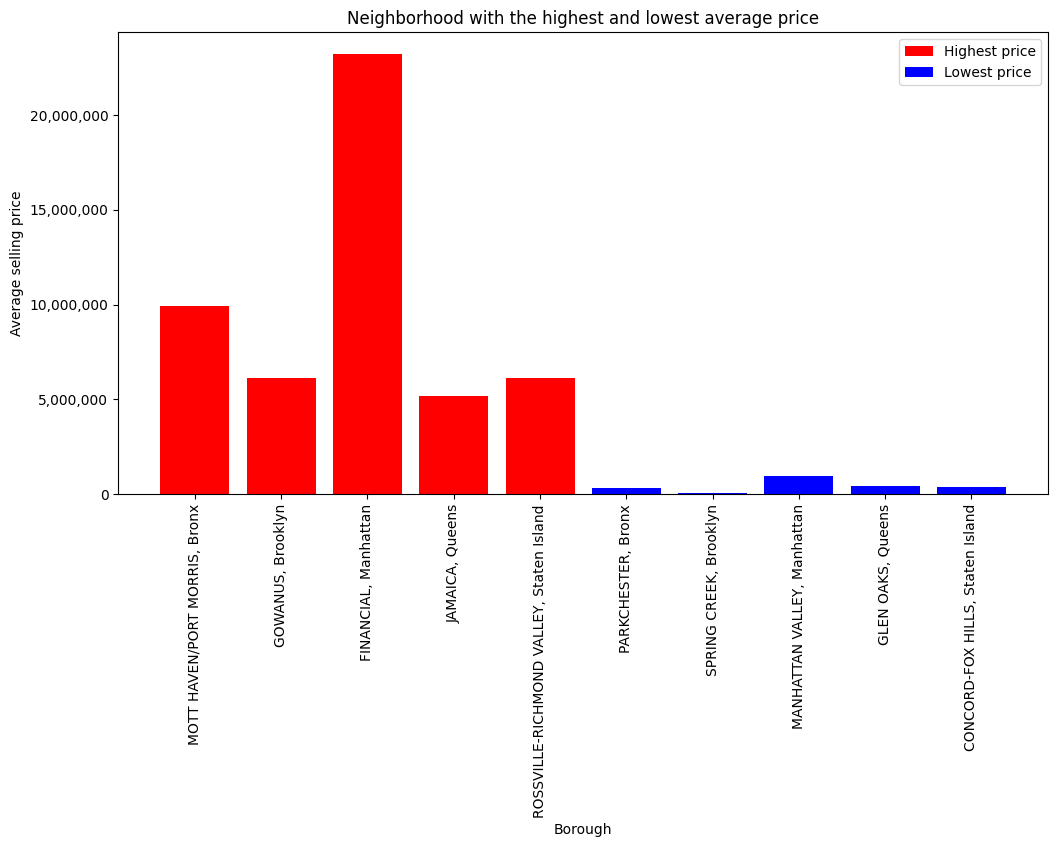

In [5]:
# Популярні та непопулярні Райони
average_prices = all_data.groupby(['BOROUGH', 'NEIGHBORHOOD'])['SALE PRICE'].mean().reset_index()

# Знаходимо район з найвищою середньою ціною в кожному BOROUGH
highest_prices = average_prices.groupby('BOROUGH')['SALE PRICE'].idxmax()
neighborhoods_with_highest_prices = average_prices.loc[highest_prices]

# Знаходимо район з найнижчою середньою ціною в кожному BOROUGH
lowest_prices = average_prices.groupby('BOROUGH')['SALE PRICE'].idxmin()
neighborhoods_with_lowest_prices = average_prices.loc[lowest_prices]

# Підготовка назв районів разом з BOROUGH для графіку
neighborhoods_highest_labels = [f'{row["NEIGHBORHOOD"]}, {row["BOROUGH"]}' for _, row in neighborhoods_with_highest_prices.iterrows()]
neighborhoods_lowest_labels = [f'{row["NEIGHBORHOOD"]}, {row["BOROUGH"]}' for _, row in neighborhoods_with_lowest_prices.iterrows()]

# Відобразимо результати на графіку
plt.figure(figsize=(12, 6))
plt.bar(neighborhoods_highest_labels, neighborhoods_with_highest_prices['SALE PRICE'], color='red', label='Highest price')
plt.bar(neighborhoods_lowest_labels, neighborhoods_with_lowest_prices['SALE PRICE'], color='blue', label='Lowest price')
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Borough')
plt.ylabel('Average selling price')
plt.title('Neighborhood with the highest and lowest average price')
plt.xticks(rotation=90)
plt.legend()
plt.show()

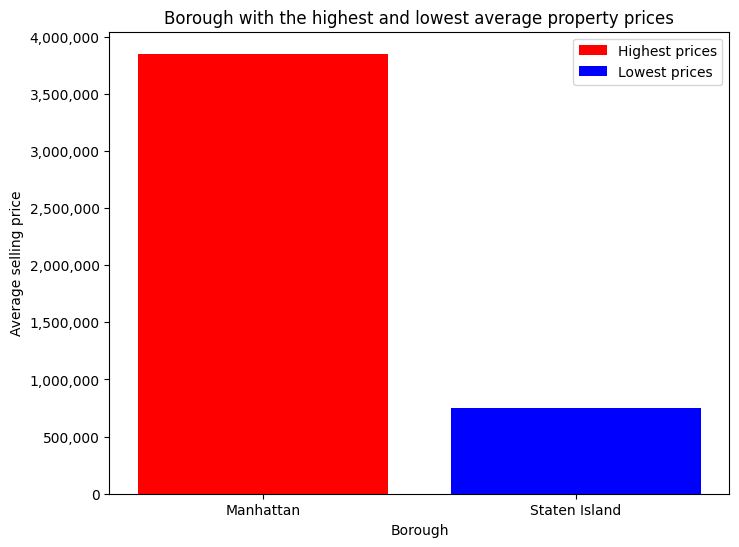

In [6]:
# Найвищі та найнижчі ціни
# Створюємо новий DataFrame, де обчислимо середню ціну для кожного BOROUGH
average_prices_by_borough = all_data.groupby('BOROUGH')['SALE PRICE'].mean().reset_index()

# Знаходимо BOROUGH з найвищою середньою ціною
highest_price_borough = average_prices_by_borough.loc[average_prices_by_borough['SALE PRICE'].idxmax()]

# Знаходимо BOROUGH з найнижчою середньою ціною
lowest_price_borough = average_prices_by_borough.loc[average_prices_by_borough['SALE PRICE'].idxmin()]

# Відобразимо результати на графіку
plt.figure(figsize=(8, 6))
plt.bar(highest_price_borough['BOROUGH'], highest_price_borough['SALE PRICE'], color='red', label='Highest prices')
plt.bar(lowest_price_borough['BOROUGH'], lowest_price_borough['SALE PRICE'], color='blue', label='Lowest prices')
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Borough')
plt.ylabel('Average selling price')
plt.title('Borough with the highest and lowest average property prices')
plt.legend()
plt.show()

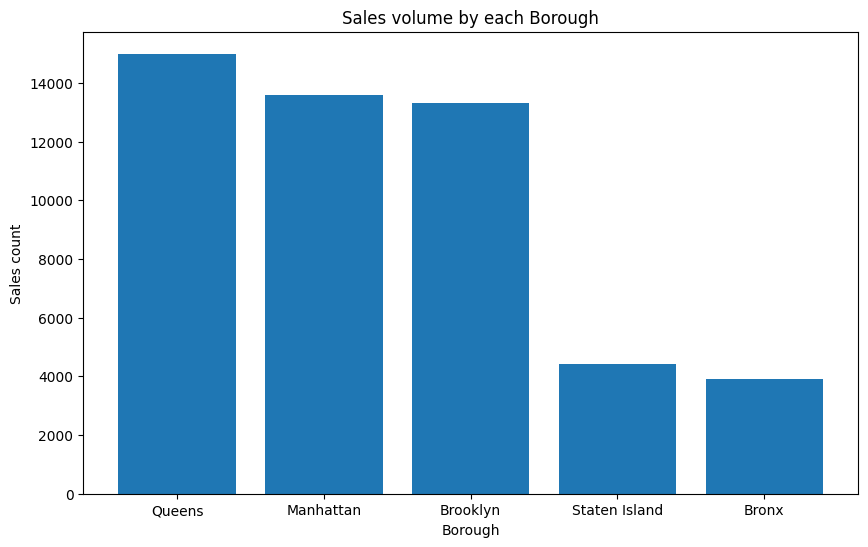

In [7]:
# Обсяг продажів
sales_by_borough = all_data['BOROUGH'].value_counts().reset_index()
sales_by_borough.columns = ['BOROUGH', 'SALES COUNT']

# Побудова графіку
plt.figure(figsize=(10, 6))
plt.bar(sales_by_borough['BOROUGH'], sales_by_borough['SALES COUNT'])
plt.xlabel('Borough')
plt.ylabel('Sales count')
plt.title('Sales volume by each Borough')
plt.show()

# print(sales_by_borough)

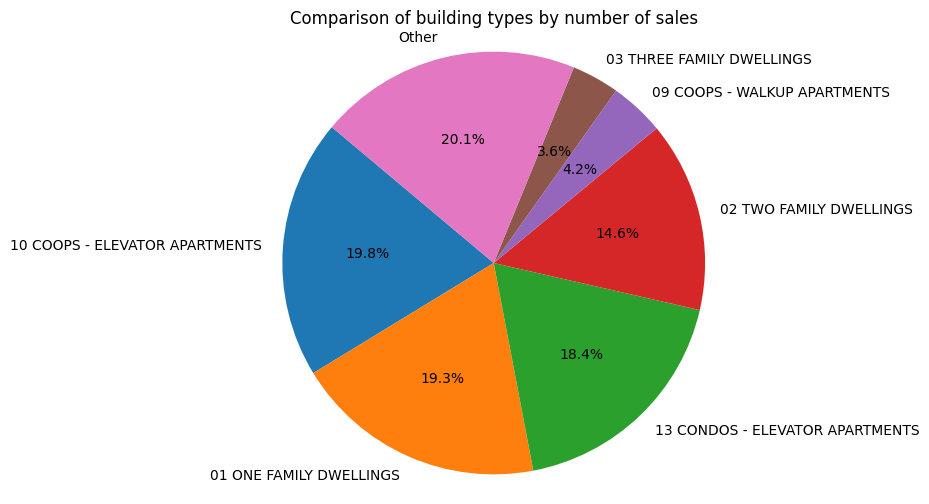

In [8]:
# Порівняння типів будівель за кількістю продажів
building_type_counts = all_data['BUILDING CLASS CATEGORY'].value_counts()
# Групуємо дані, де кількість продажів менше 1 в "Other"
threshold = 1500
building_type_counts['Other'] = building_type_counts[building_type_counts < threshold].sum()
building_type_counts = building_type_counts[building_type_counts >= threshold]

# Побудова pie chart
plt.figure(figsize=(6, 6))
plt.pie(building_type_counts, labels=building_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Робимо коло круглим
plt.title('Comparison of building types by number of sales')
plt.show()

BUILDING TYPE
RESIDENTIAL        43589
ELSE                4253
NON-RESIDENTIAL     2354
Name: count, dtype: int64
BUILDING CLASS CATEGORY
10 COOPS - ELEVATOR APARTMENTS                9955
01 ONE FAMILY DWELLINGS                       9677
13 CONDOS - ELEVATOR APARTMENTS               9248
02 TWO FAMILY DWELLINGS                       7313
09 COOPS - WALKUP APARTMENTS                  2099
03 THREE FAMILY DWELLINGS                     1826
07 RENTALS - WALKUP APARTMENTS                1483
15 CONDOS - 2-10 UNIT RESIDENTIAL             1016
44 CONDO PARKING                               977
17 CONDO COOPS                                 956
04 TAX CLASS 1 CONDOS                          886
12 CONDOS - WALKUP APARTMENTS                  607
05 TAX CLASS 1 VACANT LAND                     566
22 STORE BUILDINGS                             490
08 RENTALS - ELEVATOR APARTMENTS               365
47 CONDO NON-BUSINESS STORAGE                  318
14 RENTALS - 4-10 UNIT                       

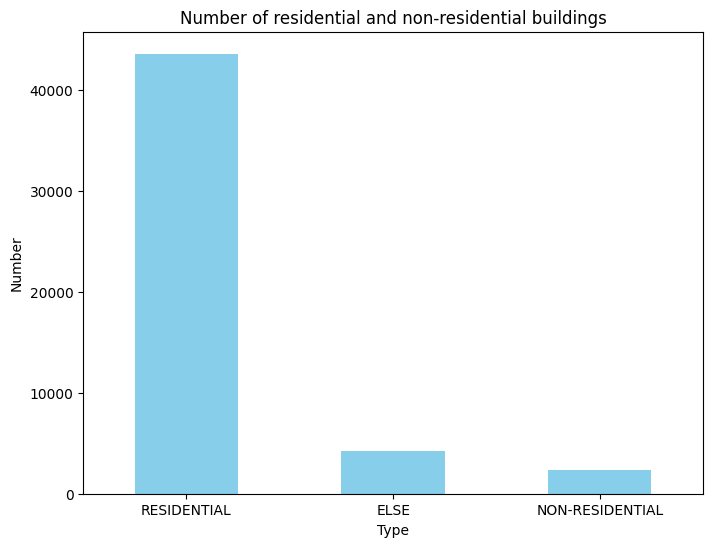

In [9]:
#Кількість житлових та нежитлових будівель
building_type_counts = all_data['BUILDING TYPE'].value_counts()
building_type_countsall = all_data['BUILDING CLASS CATEGORY'].value_counts()
print(building_type_counts)
print(building_type_countsall)
# Побудова графіку
plt.figure(figsize=(8, 6))
building_type_counts.plot(kind='bar', color='skyblue')
plt.title('Number of residential and non-residential buildings')
plt.xlabel('Type')
plt.ylabel('Number')
plt.xticks(rotation=0)
plt.show()


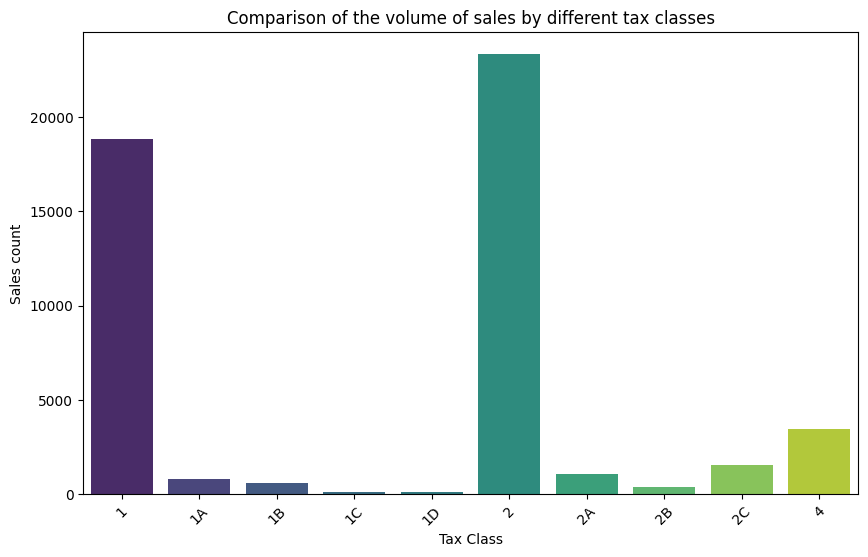

In [10]:
# Порівняння обсягу продажів за різними податковими класами
sales_by_tax_class = all_data.groupby('TAX CLASS AT PRESENT')['SALE PRICE'].count().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='TAX CLASS AT PRESENT', y='SALE PRICE', data=sales_by_tax_class,hue ='TAX CLASS AT PRESENT',palette='viridis')
plt.xlabel('Tax Class')
plt.ylabel('Sales count')
plt.title('Comparison of the volume of sales by different tax classes')
plt.xticks(rotation=45)
plt.show()

         BOROUGH  PRICE PER SQFT
0          Bronx    1.264423e+05
1       Brooklyn    5.116487e+05
2      Manhattan    2.833313e+06
3         Queens    3.711872e+05
4  Staten Island    4.674977e+04


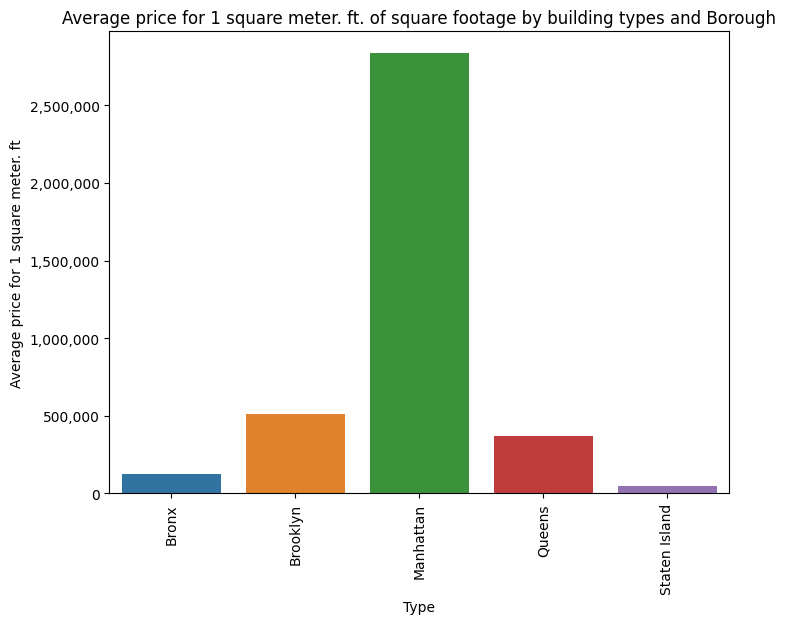

In [11]:
# Середня ціна за 1 кв. фут площі у Районі
filtered_data = all_data[(all_data['GROSS SQUARE FEET'] > 0)]
# Розрахунок ціни за 1 кв. фут площі
filtered_data.loc[:,'PRICE PER SQFT'] = filtered_data['SALE PRICE'] / filtered_data['GROSS SQUARE FEET']

# Групування та розрахунок середньої ціни за 1 кв. фут площі за типами будівель та BOROUGH
price_per_sqft_by_building = filtered_data.groupby(['BOROUGH'])['PRICE PER SQFT'].mean().reset_index()

print(price_per_sqft_by_building)
# Побудова графіку
plt.figure(figsize=(8, 6))
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
sns.barplot(data=price_per_sqft_by_building, x='BOROUGH', y='PRICE PER SQFT', hue='BOROUGH')
plt.xlabel('Type')
plt.ylabel('Average price for 1 square meter. ft')
plt.title('Average price for 1 square meter. ft. of square footage by building types and Borough')
plt.xticks(rotation=90)
plt.show()

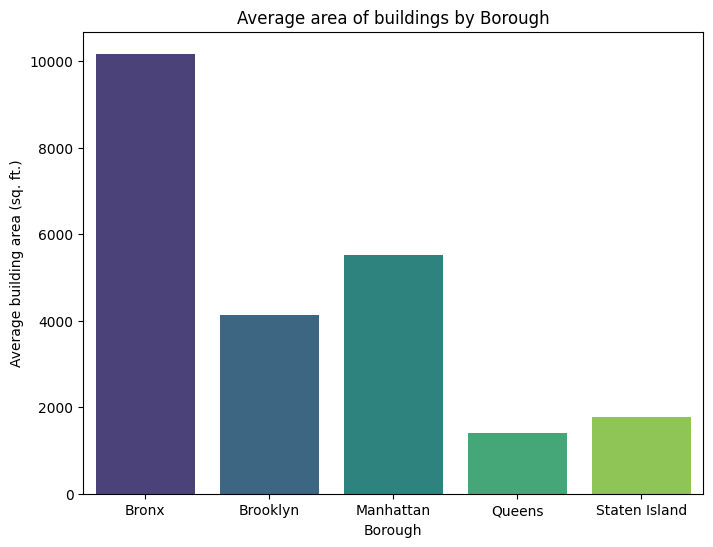

In [12]:
# Середня площа будівель за BOROUGH
filtered_data = all_data[all_data['GROSS SQUARE FEET'] > 0]

# Групування та розрахунок середньої площі за BOROUGH
average_sqft_by_borough = filtered_data.groupby('BOROUGH')['GROSS SQUARE FEET'].mean().reset_index()

# Побудова графіку
plt.figure(figsize=(8, 6))
sns.barplot(data=average_sqft_by_borough, x='BOROUGH', y='GROSS SQUARE FEET', hue='BOROUGH', palette='viridis')
plt.xlabel('Borough')
plt.ylabel('Average building area (sq. ft.)')
plt.title('Average area of buildings by Borough')
plt.show()

BOROUGH
Bronx             1607
Brooklyn         11030
Manhattan        31740
Queens           47244
Staten Island    70827
Name: GROSS SQUARE FEET, dtype: int64
             BOROUGH  GROSS SQUARE FEET
1607           Bronx            1598812
11030       Brooklyn             659725
31740      Manhattan            1291359
47244         Queens             266316
70827  Staten Island             233560


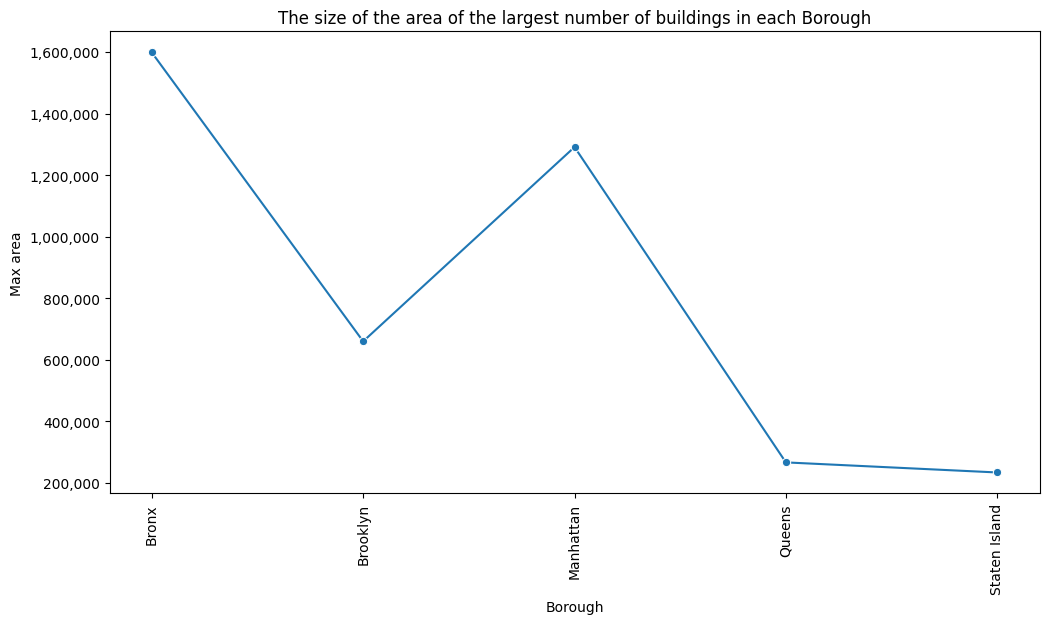

In [13]:
#Розмір площі, будівель з якою є  найбільа кількість в кожному районі
max_sqft_by_neighborhood = all_data.groupby('BOROUGH')['GROSS SQUARE FEET'].idxmax()
print(max_sqft_by_neighborhood)
neighborhood_max_sqft = all_data.loc[max_sqft_by_neighborhood, ['BOROUGH', 'GROSS SQUARE FEET']]
print(neighborhood_max_sqft)
# Побудова лінійного графіка
plt.figure(figsize=(12, 6))
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
sns.lineplot(data=neighborhood_max_sqft, x='BOROUGH', y='GROSS SQUARE FEET', marker='o')
plt.xlabel('Borough')
plt.ylabel('Max area')
plt.title('The size of the area of the largest number of buildings in each Borough')
plt.xticks(rotation=90)
plt.show()

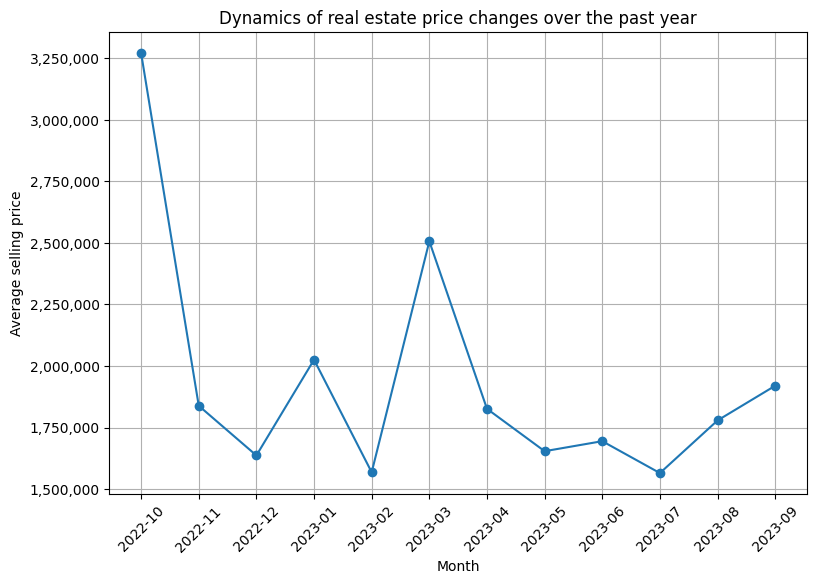

In [14]:
# Вибираємо дані за останній рік
last_year_data = all_data[all_data['SALE DATE'] >= all_data['SALE DATE'].max() - pd.DateOffset(years=1)]

# Групуємо дані за місяці та підраховуємо середню ціну
monthly_average_prices = last_year_data.groupby(last_year_data['SALE DATE'].dt.to_period('M'))['SALE PRICE'].mean()

# Перетворюємо індекс з типом "Period" у рядковий формат
monthly_average_prices.index = monthly_average_prices.index.strftime('%Y-%m')

# Побудова графіка
plt.figure(figsize=(9, 6))
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.plot(monthly_average_prices.index, monthly_average_prices.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average selling price')
plt.title('Dynamics of real estate price changes over the past year')
plt.xticks(rotation=45)
plt.grid()
plt.show()

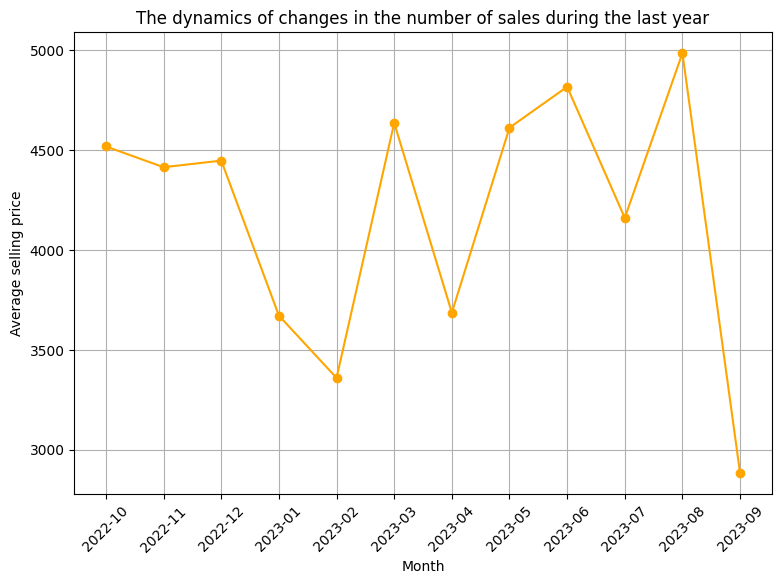

In [15]:
# Динаміка змін кількості продажів протягом останнього року
last_year_data = all_data[all_data['SALE DATE'] >= all_data['SALE DATE'].max() - pd.DateOffset(years=1)]

# Групуємо дані за місяці та підраховуємо кількість продажів
monthly_sales_counts = last_year_data.groupby(last_year_data['SALE DATE'].dt.to_period('M'))['SALE PRICE'].count()

# Перетворюємо індекс з типом "Period" у рядковий формат
monthly_sales_counts.index = monthly_sales_counts.index.strftime('%Y-%m')

# Побудова графіка
plt.figure(figsize=(9, 6))
plt.plot(monthly_sales_counts.index, monthly_sales_counts.values, marker='o', color='orange')
plt.xlabel('Month')
plt.ylabel('Average selling price')
plt.title('The dynamics of changes in the number of sales during the last year')
plt.xticks(rotation=45)
plt.grid()
plt.show()

     TOTAL UNITS    SALE PRICE
0              1  1.834314e+06
1              2  1.197924e+06
2              3  1.590548e+06
3              4  2.356486e+06
4              5  4.547651e+06
..           ...           ...
127          458  1.741402e+06
128          484  1.037419e+08
129          509  5.850000e+05
130          550  3.084000e+06
131         1272  6.000000e+06

[132 rows x 2 columns]


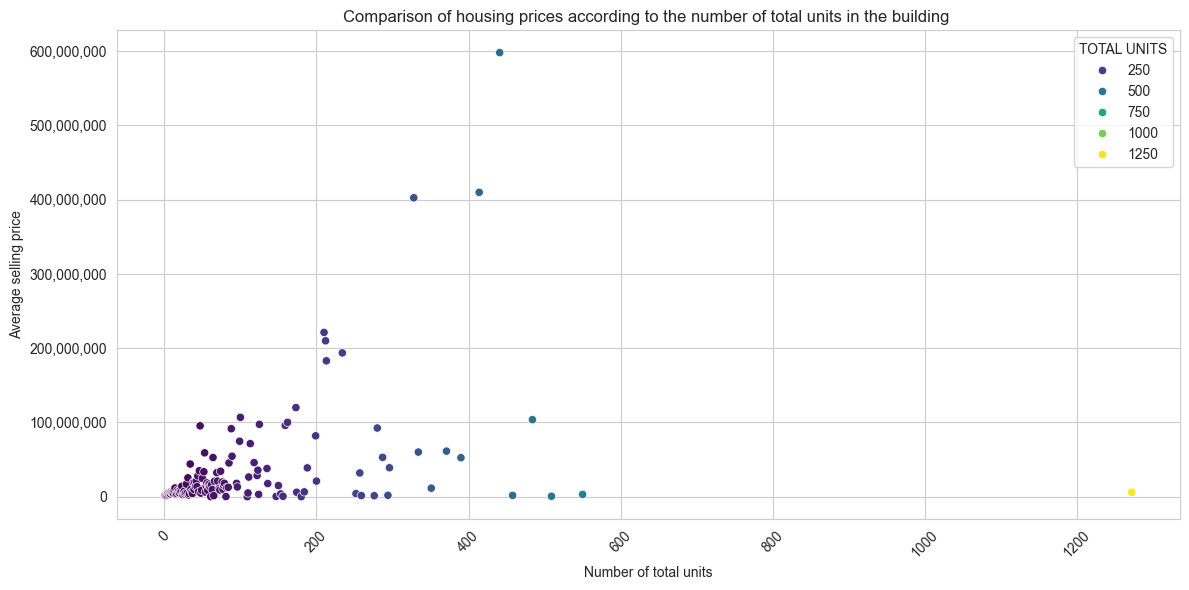

In [16]:
# Порівняння цін на житло відповідно до кількості житлових одиниць у будівлі
selected_columns = ['TOTAL UNITS', 'SALE PRICE', 'BUILDING CLASS CATEGORY']
data = all_data[selected_columns]

# # Видалімо рядки з відсутніми значеннями
# data = data.dropna()
# Згрупуємо дані за категорією будівлі та кількістю житлових одиниць та обчислимо середню ціну
grouped_data = data.groupby('TOTAL UNITS')['SALE PRICE'].mean().reset_index()
print(grouped_data)
# Побудуємо графік
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.scatterplot(data=grouped_data, x='TOTAL UNITS', y='SALE PRICE', hue='TOTAL UNITS', palette='viridis')
plt.title('Comparison of housing prices according to the number of total units in the building ')
plt.xlabel('Number of total units')
plt.ylabel('Average selling price')
plt.xticks(rotation=45)
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()